In [1]:
#Preprocessing
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import h5py
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3, venn3_circles
import pickle
import gzip
import pandas as pd
import requests
import openslide
from openslide.deepzoom import DeepZoomGenerator
from openslide import open_slide
import math
import pdb
import time
import os
import matplotlib.patches as mpatches
import pickle
import numpy as np
import h5py
%matplotlib inline

tissue_types = ['Lung', 'Artery - Tibial', 'Heart - Left Ventricle', 'Breast - Mammary Tissue', 'Brain - Cerebellum', 'Pancreas', 'Testis', 'Liver', 'Ovary', 'Stomach']
lung_expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_{}_normalised_without_inverse_gene_expression.txt'.format("Lung")

def build_empty_model():
    inception_model = InceptionV3(weights='imagenet', include_top=False)

    x = inception_model.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(input=inception_model.input, output=predictions)
    return model

def get_donor_IDs(IDlist):
    return [str(x).split('-')[1] for x in IDlist]

In [1]:
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


ImportError: libcudart.so.7.5: cannot open shared object file: No such file or directory

# Load only Lung Data

In [2]:
data_tile_number = 10
data_tile_level_index = -1
t = "Lung"
[lung_X, tl, lung_ID] = pickle.load(open('../data/processed/patches/data_{}_{}_{}.py'.format(t,data_tile_number,data_tile_level_index), 'rb'))

In [12]:
lung_X[15].shape

(299, 299, 3)

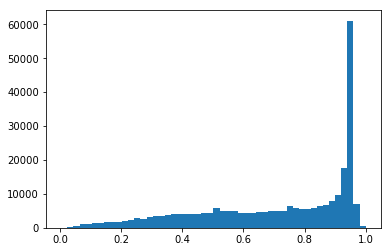

In [20]:
plt.hist( (1- lung_X[3].astype(np.float32)).flatten(), bins=50)
plt.show()

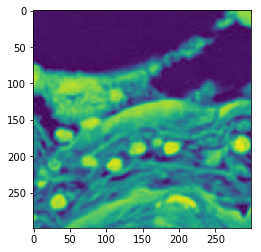

In [17]:
plt.imshow(lung_X[27][:,:,2].astype(np.float32))

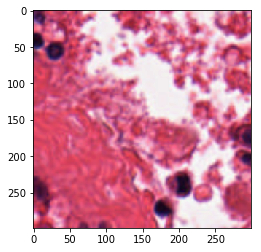

In [3]:
plt.imshow(1- lung_X[15].astype(np.float32),interpolation='none')

# Load Deep representations

In [11]:
# Generate from scratch
# model_tile_number = 50
# model_tile_level_index = -1
# model = build_empty_model()
# model.load_weights('../models/inception_50_-1_gs1.h5')

# final_layer_model = Model(model.input, model.layers[-2].output)
# lung_full_representations = final_layer_model.predict(lung_X)

# pickle.dump(lung_full_representations,open('../data/processed/representations/lung_representations_model_{}_{}_gs{}_data_{}_{}'.format(model_tile_number,model_tile_level_index,1,data_tile_number,data_tile_level_index), 'wb'))


model_tile_number = 50
model_tile_level_index = -1
lung_full_representations = pickle.load(open('../data/processed/representations/lung_representations_model_{}_{}_gs{}_data_{}_{}'.format(model_tile_number,model_tile_level_index,1,data_tile_number,data_tile_level_index), 'rb'))

# Aggregation

## Aggregation by mean

In [34]:
int(len(lung_full_representations) / 10)

NameError: name 'lung_full_representations' is not defined

In [6]:
agg_lung_full_representations = []
for i in range(int(len(lung_full_representations) / 10)):
    reps_from_person = lung_full_representations[10*i:10*(i+1),:]
    agg_reps = np.mean(reps_from_person,axis=0)
    agg_lung_full_representations.append(agg_reps)
agg_lung_full_representations = np.array(agg_lung_full_representations)
    

# Load and filter expression data for Lung

In [17]:
with open(lung_expression_filepath, 'r') as f:
    expression_table = np.array([x.split('\t') for x in f.read().splitlines()])

individual_lung_expression_donor_IDs = [x.split('-')[1] for x in expression_table[0,:][1:]]
print (len(individual_lung_expression_donor_IDs)) #278

individual_lung_image_donor_IDs = np.array(get_donor_IDs([lung_ID[data_tile_number*i] for i in range(int(len(lung_ID) / 10))]))
print (len(individual_lung_image_donor_IDs)) #93

# Filter image IDs to ones where RNA expression exists
rna_exists = np.array([x in individual_lung_expression_donor_IDs for x in individual_lung_image_donor_IDs])
print (sum(rna_exists)) #69
f_individual_lung_image_donor_IDs = individual_lung_image_donor_IDs[rna_exists]

#Find the unique indexes of these IDs in the individual donor IDs which correspond to a single aggregated representation.
f_individual_lung_IDs_reps_idx = np.unique([list(individual_lung_image_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_reps_idx)) #57

#Find the indexes of these IDs in the RNA expression
f_individual_lung_IDs_exp_idx = np.unique([list(individual_lung_expression_donor_IDs).index(x) for x in f_individual_lung_image_donor_IDs])
print (len(f_individual_lung_IDs_exp_idx)) #57

#Extract the correct data from the expression matrix and the aggregate representations.
expression_matrix = expression_table[1:,1:].astype(np.float32)

f_agg_lung_full_representations = agg_lung_full_representations[f_individual_lung_IDs_reps_idx,:]
f_expression_matrix = expression_matrix[:,f_individual_lung_IDs_exp_idx].T
print (f_agg_lung_full_representations.shape, f_expression_matrix.shape) # (57, 1024) (57, 28683)

278
93
69
57
57
(57, 1024) (57, 28683)


# Save processed data

In [3]:
pickle.dump([f_expression_matrix, f_agg_lung_full_representations], open('../data/processed/associations/lung_associations.py','wb'))

NameError: name 'f_expression_matrix' is not defined

# Perform association tests

## Load preprocessed data

In [18]:
from lim.genetics import qtl
from lim.genetics.phenotype import NormalPhenotype

import logging
lim_logging = logging.getLogger('lim')
lim_logging.setLevel(logging.CRITICAL)
[X_matrix, y_pheno] = pickle.load(open('../data/processed/associations/lung_associations.py','rb'))

upper_limit = math.floor(X_matrix.shape[1] / 100) + 1
p_values = []
f_y_pheno = y_pheno[:,0]
f_y_pheno_obj = NormalPhenotype(f_y_pheno)
for i in range(upper_limit):
    f_X_matrix = X_matrix[:, 100*i:100*(i+1)]
    G = f_X_matrix[:, 1:].copy()
#     print (f_X_matrix.shape, f_y_pheno.shape)

    lrt = qtl.scan(f_y_pheno_obj, f_X_matrix, G, progress=False)
    p_values.extend(lrt.pvalues())
    if i % 10 == 0:
        print (i)

pickle.dump(p_values, open('../data/processed/associations/lung_p_values.py','wb'))

8.5414127782e-07
3.0582330385808335e-08


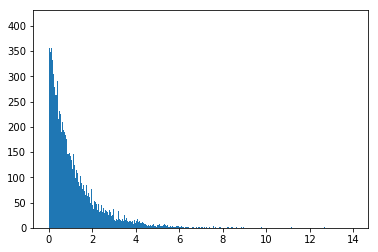

In [189]:
p_values = pickle.load(open('../data/processed/associations/lung_p_values.py','rb'))

print (np.min(p_values))

print (0.05/(28683*57))

plt.hist([-math.log(x) for x in p_values],bins=1000)
plt.show()

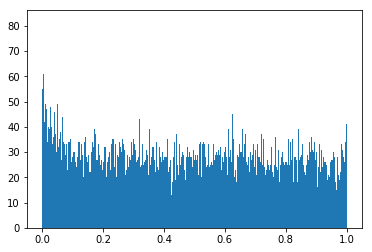

In [172]:
plt.hist(p_values,bins=1000)
plt.show()
